# 0.0 Table of Contents

1. [Introduction](#1.0-Introduction)

2. [Feature Analysis](#2.0-Feature-Analysis)

# 1.0 Introduction
 

### 1.1 Project -  Binary classification of bitcoin addresses

-  **GOAL:** to predict whether an address has been the recipient of ransomware coins. 

-  **DATA:**  Data is time series (24hr chunks) derived from the topological and geometrical properties of the bitcoin network.

### 1.2 Basics

- Ransomware is a rogue compute code that encrypts the victim's filesystem unless money is paid to the attacker for decryption. 

- Bitcoin is often used for these payments because it provides a semi-anonymous transaction method.  

- The dataset was taken from the UCI Machine Learning Repository. It contains labelled data of addresses according to whether they have been involved in Ransomware. The data is from 2009 January to 2018 December. 
- Link to the data-set: [click here](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset)

### 1.2.0 Breakdown

---
**"starter transactions"**: transactions which are spent outputs from the  previous time window <n>

Features:

- The **address** is a public BC address which can receive and send bitcoins.        
- The **income** of an address $a$ is the total amount of coins output to it measured in Satoshis (1 millionth of a BC).
- The number of (in) **neighbors** of an address $a$  is the number of transactions which
have $a$ as one of its output addresses.
- The **weight** of an address is the sum of the fraction of *coins* that come from a starter transaction and merge at the address. Weight quantifies the merge behavior (i.e., the transaction has more input addresses than output addresses), where coins
in multiple addresses are each passed through a succession of
merging transactions and accumulated in a final address.
- The **length** of an address $a$ is the number of non-starter transactions connected to $a$ on the longest chain.  A length of zero implies that the address is the recipient of starter transaction.
- The **count** of an address $a$ is the number of starter transactions
which are connected to $a$ in a chain, where a chain is
defined as an acyclic directed path originating from a starter
transaction and ending at address $a$. Count captures
information about the number of transactions, whereas weight
 gives information about the amount of coins.
- **looped** is the number of starter transactions connected to $a$ by more than one path (chain). 
    
       
<n>
Engineered/derived features:
    
- bc_income = boxcox of income
    
- bc_length = boxcox of length
    
- yeo_weight = yeo of weight
   
- logbc_n_address = boxcox log of address

- bc_neighbors = box of neighbors
   
- sig_looped = sigmoid of looped
    
- log_count = log of count
   
- day_of_week = {'Monday':0,...,'Sunday': 6}

### 1.3 Packages and helper functions

In [473]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from tqdm.notebook import tqdm
import os
import pickle
import pdb
import datetime
import warnings

from scipy.stats import pearsonr
from scipy import stats
from scipy.stats import boxcox, yeojohnson
from scipy.stats import shapiro

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, log_loss, plot_roc_curve, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from prettytable import PrettyTable

from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore", category=UserWarning)
_ = np.seterr(over='ignore')
#from pretty_confusion_matrix import plot_confusion_matrix_from_data as conf_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)

In [230]:
pd.options.mode.chained_assignment = None  # default='warn'

In [231]:
RAND_STATE  = 42
SPLIT_RATIO = 0.23
SAVE_TEST_TRAIN = False
DS_FRAC = .25
NF = 7

### 1.4 Importing data

In [232]:
df = pd.read_csv('data/BitcoinHeistData.csv')
df = df.sample(frac=DS_FRAC, axis=0,random_state=RAND_STATE)
ROWS = df.shape[0]
COLS = df.shape[1]
ROWS,COLS


(729174, 10)

In [233]:
# copy a data frame
dfc = df.copy()

In [234]:
df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
2667698,15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ,2018,82,8,1.311111,3,0,2,577264100.0,white
2013400,3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ,2016,157,2,0.025000,44,0,1,100000000.0,white
2704440,3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw,2018,118,144,3.619217,5991,5991,2,299950000.0,white
1650833,1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y,2015,160,144,0.000484,3452,3049,2,299000000.0,white
1586811,175gAXqbkq4nho268FZxoBZ7TCCZWzWcg,2015,96,128,0.625000,2,0,2,40000000.0,white


In [235]:
remove_words = ["princeton","padua","montreal"]
for r in remove_words:
    dfc['label']=dfc['label'].str.replace(r,"")
    df['label']=df['label'].str.replace(r,"")

For each time window extending back from the t_now, we take a sample of addresses

In [8]:
years = df['year'].unique()
print('The data extends from {} to {}.'.format(years.min(),years.max()))
print('File containts {:d} rows and {} columns'.format(df.shape[0], df.shape[1]))


The data extends from 2011 to 2018.
File containts 291670 rows and 10 columns


In [9]:
features=list(df.columns)[:-1]
print('Feature columns: \n{}'.format(features))

Feature columns: 
['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']


In [10]:
print('Datatypes: \n\n{}'.format(df.dtypes))

Datatypes: 

address       object
year           int64
day            int64
length         int64
weight       float64
count          int64
looped         int64
neighbors      int64
income       float64
label         object
dtype: object


In [236]:
top_ransomwares_dict = dict(dfc.label.value_counts().head(10)[1:])
top10_ransoms_labels = dfc.label.value_counts()[1:11]
print('The top ransomware types are')
top10_ransoms_labels

The top ransomware types are


CryptoWall      3008
CryptoLocker    2322
Cerber          2209
Locky           1628
CryptXXX         617
NoobCrypt        101
DMALockerv3       93
DMALocker         50
SamSam            16
Globe             11
Name: label, dtype: int64

In [237]:
print('The data is over 95% unbalanced towards clean!\n\nwhite label cnt: {}\nrannsomware label cnt: {}'\
      .format(df['label'].value_counts()[0], 
        sum(df['label'].value_counts()[1:])
             ))


The data is over 95% unbalanced towards clean!

white label cnt: 719067
rannsomware label cnt: 10107


### 1.5 Cleaning the data

- check for corrupted, missing, or duplicated entries

In [238]:
df.isnull().any() # check for null values

address      False
year         False
day          False
length       False
weight       False
count        False
looped       False
neighbors    False
income       False
label        False
dtype: bool

In [239]:
print('The data is free of obvious null values')

The data is free of obvious null values


In [240]:
df = df.drop_duplicates() # if any

### 1.6 Exploration of top ransomware accounts

,address,year,day,length,weight,count,looped,neighbors,income,label
2667698,15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ,2018,82,8,1.311111,3,0,2,5.772641e+08,white
2013400,3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ,2016,157,2,0.025000,44,0,1,1.000000e+08,white
2704440,3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw,2018,118,144,3.619217,5991,5991,2,2.999500e+08,white
1650833,1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y,2015,160,144,0.000484,3452,3049,2,2.990000e+08,white
1586811,175gAXqbkq4nho268FZxoBZ7TCCZWzWcg,2015,96,128,0.625000,2,0,2,4.000000e+07,white
...,...,...,...,...,...,...,...,...,...,...
2801004,1NcRJirxHXN3PYEEdgdimwd2WBjxiDNfoG,2018,215,0,1.000000,1,0,2,1.112954e+08,white
1279778,1AqiakQAVAkNfacgoxomCDLe62TNBBhAzE,2014,154,144,0.825244,1756,1746,2,4.298373e+08,white
2286818,3PbboqPBfQoArgYn9DohRzTCTWu4euCduy,2017,66,0,1.000000,1,0,1,3.468740e+07,white
287632,1GZvWujtmYKfaVA9mYw954hwkdjrrMuCp5,2011,256,28,0.007994,44,0,2,7.998859e+09,white


In [442]:
top_ransomwares_dict = dfc[dfc['label']!='white']['address'].value_counts().head(5).to_dict()
dfc[dfc['label']!='white']['address'].value_counts().head(5).to_dict()
top_ransomwares_l = list(top_ransomwares_dict.keys())
top_accts = [dfc[dfc['address'] == j] for j in top_ransomwares_l]

In [460]:
top_accts[0].describe()

,year,day,length,weight,count,looped,neighbors,income
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,1.010000e+02
mean,2013.386139,181.930693,7.485149,1.324719,43.930693,0.019802,1.554455,4.791904e+09
std,0.489291,106.086875,26.751678,0.620879,270.717316,0.199007,0.767792,1.695253e+10
min,2013.000000,5.000000,0.000000,0.000096,1.000000,0.000000,1.000000,4.076000e+07
25%,2013.000000,92.000000,0.000000,1.000000,1.000000,0.000000,1.000000,6.354000e+08
50%,2013.000000,171.000000,0.000000,1.000000,2.000000,0.000000,1.000000,1.946310e+09
75%,2014.000000,277.000000,2.000000,1.500000,2.000000,0.000000,2.000000,4.461540e+09
max,2014.000000,365.000000,144.000000,3.312269,2319.000000,2.000000,4.000000,1.687649e+11


In [455]:
top_accts[0]['weight'].value_counts(normalize=True,bins=4)

(0.828, 1.656]       0.683168
(1.656, 2.484]       0.128713
(-0.00422, 0.828]    0.108911
(2.484, 3.312]       0.079208
Name: weight, dtype: float64

In [454]:
top_accts[0]['count'].value_counts(normalize=True,bins=4)

(-1.319, 580.5]     0.980198
(1160.0, 1739.5]    0.009901
(1739.5, 2319.0]    0.009901
(580.5, 1160.0]     0.000000
Name: count, dtype: float64

In [528]:
top_accts[0]['looped'].value_counts(normalize=True,bins=4)


(-0.003, 0.5]    0.990099
(1.5, 2.0]       0.009901
(0.5, 1.0]       0.000000
(1.0, 1.5]       0.000000
Name: looped, dtype: float64

In [529]:
top_df = top_accts[0]

In [532]:
top_df['time']= ''

In [533]:
def convert_times(df):
    start = 2011
    year = 365
    for idx, row in df.iterrows():
        fact = (df['year'][idx]-start)*year
        df['time'][idx] = df['day'][idx] + fact
    return df

In [534]:
top_df = convert_times(top_df)

In [535]:
top_df.drop(['day', 'year'], axis=1, inplace=True)

In [536]:
import matplotlib.pyplot as plt

In [537]:
top_df.sort_values(by=['time'], ascending=True,inplace=True)

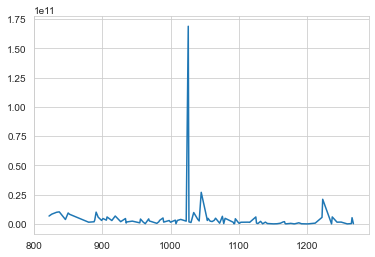

In [538]:
plt.plot(top_df['time'],top_df['income'])

In [539]:
np.std(top_df['count'])

269.37379739184337

In [540]:
top_df['time'].value_counts()

822     1
1103    1
1142    1
1139    1
1135    1
       ..
984     1
983     1
980     1
969     1
1268    1
Name: time, Length: 101, dtype: int64

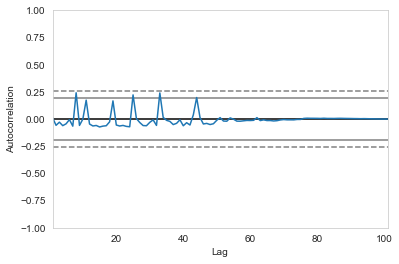

[]

In [541]:
tmp = pd.plotting.autocorrelation_plot(top_df['length'])
plt.show()
tmp.plot()

In [542]:
top_df

,address,length,weight,count,looped,neighbors,income,label,time
34065,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,4,1.00,2,0,1,6.760220e+09,CryptoLocker,822
34135,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2,1.50,2,0,2,8.376640e+09,CryptoLocker,826
34157,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,0,1.00,1,0,1,9.973540e+09,CryptoLocker,833
34073,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2,1.00,2,0,2,1.033522e+10,CryptoLocker,837
34070,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,0,1.00,1,0,1,3.799540e+09,CryptoLocker,846
...,...,...,...,...,...,...,...,...,...
34075,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,0,1.00,1,0,1,1.610340e+09,CryptoLocker,1250
33985,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,0,1.00,1,0,1,5.925000e+07,CryptoLocker,1259
34249,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,0,1.00,1,0,1,3.171300e+08,CryptoLocker,1265
34097,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2,2.25,2,2,3,5.342960e+09,CryptoLocker,1266


In [30]:
top_df['income'].autocorr(lag=2)

-0.10331646393177565

In [33]:
year_vars = df.groupby('year').var()


In [34]:
year_vars

,day,length,weight,count,looped,neighbors,income
year,,,,,,,
2011,10640.092779,941.811666,0.602399,7.782987e+02,8.203313e+01,2.377670,1.931484e+23
2012,11068.814072,2075.513736,7.803078,1.966471e+05,5.677411e+04,508.052064,1.056930e+22
2013,11148.814793,2312.595587,14.107738,6.781572e+05,1.757465e+05,262.404180,2.975309e+21
2014,11055.107209,4339.553603,2.611388,7.206790e+05,5.124574e+05,24.585218,1.284803e+20
2015,10999.204134,4541.401051,31.181484,2.895797e+06,1.750638e+06,35.553089,5.255236e+20
2016,10918.650097,3937.921899,7.183563,3.978499e+06,1.397704e+06,54.592590,7.627649e+20
2017,11141.410109,3553.734728,4.558745,6.089127e+06,1.554984e+06,169.433263,1.371904e+21
2018,9071.873630,3779.567804,232.518876,6.413728e+06,1.729087e+06,6933.467385,2.011246e+21


In [586]:
mean_white_per_yr = df[df['label'] == 'white'].groupby('year').mean()
mean_red_per_yr = df[df['label'] != 'white'].groupby('year').mean()



In [588]:
yrs = list(mean_red_per_yr['income'].index)
yrs

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

In [589]:
temp=np.array(dfc.groupby('year').income.mean()).reshape((-1,1))
temp

array([[1.14920907e+10],
       [1.00711654e+10],
       [4.00750104e+09],
       [1.67897771e+09],
       [1.89057254e+09],
       [1.87414534e+09],
       [1.76914907e+09],
       [1.69124335e+09]])

<BarContainer object of 8 artists>

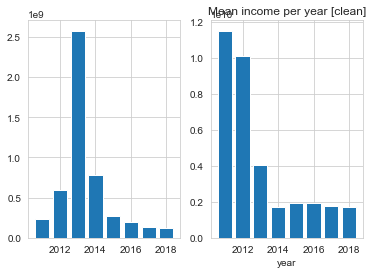

In [643]:
fig, ax = plt.subplots(1,2)
plt.title('Mean income per year [clean]')
plt.xlabel('year')
ax[0].bar(yrs,mean_red_per_yr['income'])
ax[1].bar(yrs,mean_white_per_yr['income'])

<AxesSubplot:ylabel='income'>

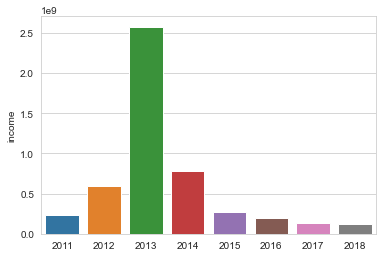

In [627]:
sns.barplot(yrs,mean_red_per_yr['income'],label='red')

### 1.7 X,y split

In [241]:
def labels_to_binary(df_labels):
    # joins the classes of ransomware labels and into 'detected'=1, 'not detected'=0
    
    labels = np.array([])
    
    for label_i in tqdm(df_labels):
        if label_i == 'white':
            # label all presumed "white" addresses with 0
            labels = np.append(labels, 0) 
        else:
            # label all ransomware addresses with 1
            labels = np.append(labels, 1) #ransomware
    return labels

In [242]:
labels = labels_to_binary(df.label) # recast labels into binary

  0%|          | 0/729174 [00:00<?, ?it/s]

In [243]:
labels_df = pd.DataFrame(labels,columns=['labels'])

In [244]:
print('Percentage of labels \
belonging to ransomware class: {:.2}'.format( (sum(labels) / len(labels)) * 100) )

Percentage of labels belonging to ransomware class: 1.4


**Defining {X, X_test, x_rain, y_test, y_train}**

In [245]:
X_df = df.drop(['label'],axis=1) # X=features [original]
X = X_df.to_numpy()

In [248]:
labels_df = labels_df.astype(int)

In [249]:
# WORKING test train split. We perform many operations on this data
# We will down sample this data for plotting, testing, and training optimization
X_train, X_test, y_train, y_test = train_test_split(
    X_df,
    labels_df,                      # y 
    stratify = labels,           #  stratify preserves the large imbalance in the target variable
    random_state = RAND_STATE,
    test_size = SPLIT_RATIO
)

In [250]:
#if SAVE_TEST_TRAIN == True:
#    with open('X_train_y_train_X_test_y_test_label_v3_01.pickle', 'wb') as save_file:
#        pickle.dump([X_train, y_train, X_test, y_test], save_file)

if SAVE_TEST_TRAIN == True:
    fname = 'X_train_y_train_X_test_y_test_v2_0'+str(NF)+'.pickle'
    with open(fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)

# 2.0 Feature Analysis

* Transform features to reduce their skew
* Normalize to unit variance and zero mean for distance classification
* Engineer new features from the old ones

In [251]:
pt = PowerTransformer(method='box-cox') # transformer to reduce skew, not standard

In [252]:
def plot_box(col_var):
        return sns.boxplot(x=col_var)
def plot_pdf(col_var, title=''):
        # plots distributions

        #self.col = s.name
        sns.distplot(col_var, color="c")
        plt.title(title +  ' distribution')
        plt.ylabel('$\pho')
        plt.xlabel(col_var.name)
        plt.plot()

In [253]:
class Feature:
    def __init__(self, df, colname):
        self.df = df
        self.col = colname
        self.vec = np.array(self.df[self.col])
        self.series = self.df[self.col]
        if self.series.dtype == 'O':
            pass
        else:
            self.skew = self.series.skew()
            self.mean = self.series.mean()
            self.var  = self.series.var()
            self.std  = self.series.std()
    def plot_pdf(self):
        # plots distributions
        sns.distplot(self.series, color="c")
        plt.title(str(self.col) +  ' distribution')
        plt.ylabel('density')
        plt.xlabel(self.col)
        plt.plot()
    def plot_box(self):
        return sns.boxplot(x=self.series)
    def apply_pt_for_plots(self):
        return pt.fit_transform(self.vec.reshape(-1,1))
    def bc(self):
        # boxcox on column
        return  boxcox(self.series)[0] 
    def yeo(self):   
        # yeo on column
        return  yeojohnson(self.series)[0] 
    def sigmoid(self):
        # logistic function
        return 1 / (1 + np.exp(-self.vec))

In [254]:
train_features = {
    "address": Feature(X_train,'address'),
    "income": Feature(X_train,'income'),
    "day": Feature(X_train, 'day'),
    "year": Feature(X_train,'year'),
    "length": Feature(X_train, 'length'),
    "weight": Feature(X_train, 'weight'),
    "neighbors": Feature(X_train,'neighbors'),
    "count": Feature(X_train,'count'),
    "looped": Feature(X_train,'looped')}

test_features = {
    "address": Feature(X_test,'address'),
    "income": Feature(X_test,'income'),
    "day": Feature(X_test, 'day'),
    "year": Feature(X_test,'year'),
    "length": Feature(X_test, 'length'),
    "weight": Feature(X_test, 'weight'),
    "neighbors": Feature(X_test,'neighbors'),
    "count": Feature(X_test,'count'),
    "looped": Feature(X_test,'looped')}

In [255]:
train_features_d = {} # derived through transformations to be more normally distributed and on smaller domains
test_features_d = {}

train_features_d['year'] = Feature(X_train,'year')
test_features_d['year']  = Feature(X_test,'year')

#### 2.1.0 income [bc_income]

In [256]:
train_features['income'].series.describe()

count    5.614630e+05
mean     4.272640e+09
std      1.453427e+11
min      3.000000e+07
25%      7.408249e+07
50%      1.999900e+08
75%      9.941911e+08
max      4.966515e+13
Name: income, dtype: float64

In [462]:
train_features['income'].series.value_counts(bins=5)

(-49635122076.175, 9933054415234.8]       561456
(39732127660939.2, 49665152076174.0]           4
(9933054415234.8, 19866078830469.6]            2
(19866078830469.6, 29799103245704.402]         1
(29799103245704.402, 39732127660939.2]         0
Name: income, dtype: int64

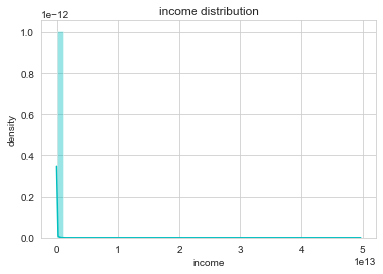

In [257]:
train_features['income'].plot_pdf()

The Shapiro–Wilk test tests the null hypothesis that a sample x1, ..., xn came from a normally distributed population.

In [489]:
#shapiro(train_features['income'].series)
shapiro(X_train['income'])

stats.anderson(X_train.income, dist='norm')

AndersonResult(statistic=205270.3457565758, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [258]:
print('Income skew = {}'.format(train_features['income'].skew)) # highly skwewed

Income skew = 250.7389157110026


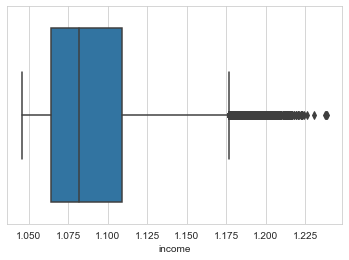

In [259]:
# reducing skew with log
log_inc = np.log(np.log(np.log(X_train['income'])))
ax = plot_box(log_inc)

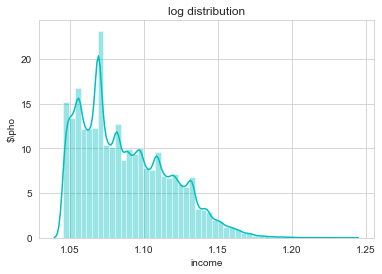

In [260]:
plot_pdf(log_inc, 'log')

Log doesn't quite normalize the distribution. Try with boxcox

In [261]:
# boxcox 
bc_income_train = train_features['income'].bc() # np array
bc_income_test = test_features['income'].bc()   # np array

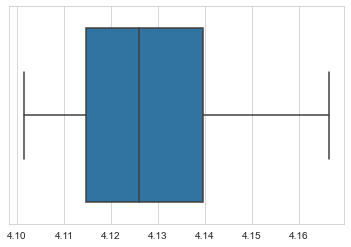

In [262]:
ax = plot_box(bc_income_train) # box plot of boxcox(income)

Applying the box-cox transform has removed the outliers

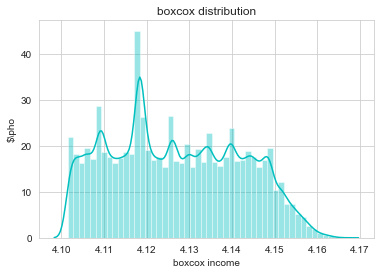

In [263]:
plot_pdf(pd.Series(bc_income_train, name='boxcox income'), 'boxcox')

In [264]:
# Seems good enough to save as a new engineered feature
train_features_d['bc_income'] = Feature(pd.DataFrame(bc_income_train, columns=['bc_income']),'bc_income')
test_features_d['bc_income']  = Feature(pd.DataFrame(bc_income_test, columns=['bc_income']),'bc_income')

In [265]:
train_features_d['bc_income'].skew

0.15785959251757625

In [479]:
shapiro(test_features_d['bc_income'].series)


ShapiroResult(statistic=0.8034206628799438, pvalue=0.0)

#### 2.1.1 day [day_of_week]

In [272]:
train_features['day'].series.describe()

count    561463.000000
mean        181.614723
std         103.921732
min           1.000000
25%          92.000000
50%         181.000000
75%         271.000000
max         365.000000
Name: day, dtype: float64

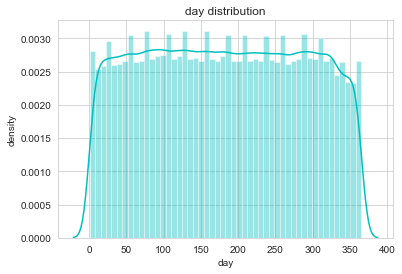

In [273]:
train_features['day'].plot_pdf()

In [274]:
print('The distribution in days is pretty flat. has only minor skew s = {}'.format(train_features['day'].series.skew()))


The distribution in days is pretty flat. has only minor skew s = 0.01044502861126917


We don't need to transform day


In [275]:
train_features_d['day'] = Feature(X_train,'day')
test_features_d['day'] = Feature(X_test,'day')

###### Engineering day of week feature

In [276]:
def get_day_number(first_day_of_year, day):
    # day number (0 for monday, 6 for sunday) for day
    return (first_day_of_year + day - 1) % 7

In [277]:
day_of_week_train = np.array([])
for index, row in tqdm(X_train.iterrows()):
    # For each data-point, we consider its year and day 
    # and calculate what day of the week (Monday, Tuesday, etc)
    # it was when the transaction happened
    # datetime.datetime(year, 1, 1).weekday() returns the first day of the year
    # using this information, we can calculate the present day

    year_i, day_i = row['year'], row['day']
    day_of_week_train = np.append(day_of_week_train, \
                                  get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

0it [00:00, ?it/s]

In [278]:
day_of_week_test = np.array([])
for index, row in tqdm(X_test.iterrows()):
    #same as above but for test set

    year_i, day_i = row['year'], row['day']
    day_of_week_test = np.append(day_of_week_test, \
                                 get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

0it [00:00, ?it/s]

In [280]:
train_features_d['day_of_week'] = Feature(pd.DataFrame(day_of_week_train.astype(int),columns=['day_of_week']),'day_of_week')
test_features_d['day_of_week'] = Feature(pd.DataFrame(day_of_week_test.astype(int),columns=['day_of_week']),'day_of_week')

####  2.1.2 length [bc_length]

In [283]:
train_features['length'].series.describe()

count    561463.000000
mean         44.950267
std          58.946800
min           0.000000
25%           2.000000
50%           8.000000
75%         108.000000
max         144.000000
Name: length, dtype: float64

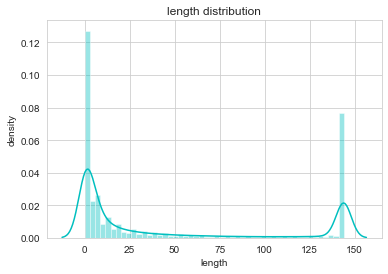

In [282]:
train_features['length'].plot_pdf()

In [464]:
train_features['length'].series.value_counts(bins=2)

(-0.145, 72.0]    406526
(72.0, 144.0]     154937
Name: length, dtype: int64

In [475]:
shapiro(train_features['length'].series)

ShapiroResult(statistic=0.6907636523246765, pvalue=0.0)

This has the form of a bimodal distribution according to the Shapiro test (p<0.05 we )


In [302]:
dfc[dfc['label']!='white'].groupby('label')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
APT,2.0,73.000000,100.409163,2.0,37.5,73.0,108.5,144.0
Cerber,2209.0,41.134450,56.942449,0.0,2.0,8.0,66.0,144.0
CryptConsole,3.0,50.666667,80.927951,0.0,4.0,8.0,76.0,144.0
CryptXXX,617.0,48.716370,58.409095,0.0,2.0,16.0,104.0,144.0
CryptoLocker,2322.0,31.226529,50.783753,0.0,0.0,4.0,30.0,144.0
CryptoTorLocker2015,10.0,19.200000,43.991918,2.0,4.0,4.0,7.5,144.0
CryptoWall,3008.0,47.710106,61.804683,0.0,0.0,8.0,144.0,144.0
DMALocker,50.0,37.160000,59.921159,0.0,0.0,2.0,60.5,144.0
DMALockerv3,93.0,42.064516,61.743827,0.0,0.0,4.0,144.0,144.0


In [472]:
dfc[dfc['label']=='white'].groupby('label')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
white,719067.0,44.984759,58.956648,0.0,2.0,8.0,108.0,144.0


In [303]:
dfc[dfc['label']!='white'].groupby('label')['length'].median()

label
APT                     73.0
Cerber                   8.0
CryptConsole             8.0
CryptXXX                16.0
CryptoLocker             4.0
CryptoTorLocker2015      4.0
CryptoWall               8.0
DMALocker                2.0
DMALockerv3              4.0
EDA2                   144.0
Flyper                   7.0
Globe                    6.0
GlobeImposter            4.0
Globev3                 74.0
JigSaw                  13.0
Locky                    7.0
NoobCrypt                0.0
Razy                    54.0
Sam                      6.0
SamSam                  11.0
VenusLocker             10.0
WannaCry                75.0
XLocker                144.0
XLockerv5.0              8.0
XTPLocker              144.0
Name: length, dtype: float64

In [467]:
dfc[dfc['label'] != 'white'].groupby('label')['length'].describe()['mean'].mean()

49.904383033479796

In [305]:
train_features['length'].skew # check how symmetric the pdf is

0.926722338090165

In [76]:
# check whether log and sqrt help the skew
X_tra_v = train_features['length'].vec
opsXa = np.log(np.sqrt(X_tra_v + 1e-6))
train_features['length'].skew, np.sqrt(X_train['length']).skew(), pd.Series(opsXa).skew()


(0.9301063947466278, 0.5786997644611137, -1.0686297218222065)

In [306]:
#constructing the feature
bc_length_train = boxcox((np.sin(np.log(np.sqrt(np.array(X_train['length']) + 1e-6))))**2)[0]
bc_length_test  = boxcox((np.sin(np.log(np.sqrt(np.array(X_test['length']) + 1e-6))))**2)[0]

In [307]:
# new features
train_features_d['bc_length'] = Feature(pd.DataFrame(bc_length_train, columns=['bc_length']),'bc_length')
test_features_d['bc_length'] = Feature(pd.DataFrame(bc_length_test, columns=['bc_length']),'bc_length')

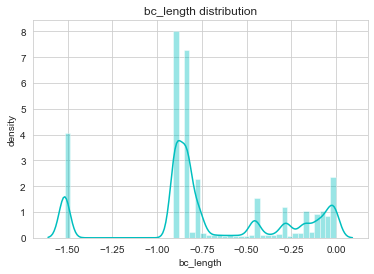

In [309]:
train_features_d['bc_length'].plot_pdf()

In [310]:
train_features_d['bc_length'].skew # the skew has improved but it's now biased

-0.03206929862926806

#### 2.1.3 weight [yeo_weight]

In [312]:
train_features['weight'].series.describe()

count    5.614630e+05
mean     5.462778e-01
std      4.606104e+00
min      3.606469e-94
25%      2.183655e-02
50%      2.500000e-01
75%      8.833250e-01
max      1.943749e+03
Name: weight, dtype: float64

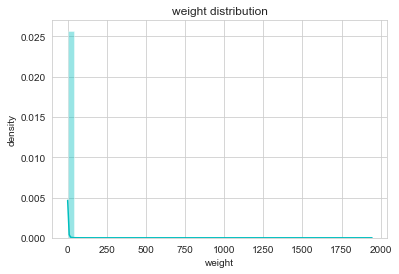

In [313]:
train_features['weight'].plot_pdf()

In [314]:
train_features['weight'].skew # very skewed!

280.4573588750912

In [321]:
train_features_d['yeo_weight'] = Feature( pd.DataFrame(train_features['weight'].yeo(),
                    columns=['yeo_weight']),'yeo_weight' )
test_features_d['yeo_weight'] = Feature( pd.DataFrame(test_features['weight'].yeo(),
                    columns=['yeo_weight']),'yeo_weight' )

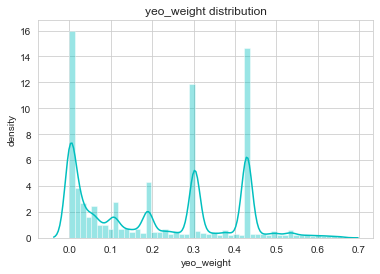

In [322]:
train_features_d['yeo_weight'].plot_pdf()

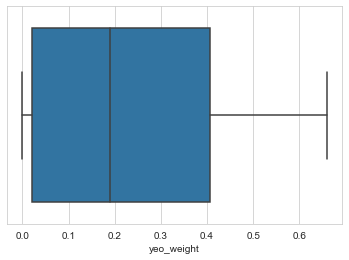

In [323]:
#plotting box plots
ax = plot_box(train_features_d['yeo_weight'].series)

#sns.boxplot(x=yeo_weight_train_ft.series)

In [324]:
train_features_d['yeo_weight'].skew

0.23440638184372953

#### 2.1.4 address [logbc_n_address]

In [325]:
train_features_d['address'] = Feature(X_train,'address')
test_features_d ['address'] = Feature(X_test, 'address')


In [326]:
X_train_address_ft = Feature(X_train,'address')
X_test_address_ft  = Feature(X_test,'address')

In [327]:
X_train['address'].value_counts()

1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU    76
16cVG72goMe4sNqZhnpmnqfCMZ1uSFbUit    60
12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza    40
1LEq4WmpCrqBd7V3PywE2nvFUFC3QTe52x    38
1CVWpTNwNYGdKgZRohiiVFrnFNbw8anG9     35
                                      ..
3PRnPsknHbyxh7bmEz2JExAsnxjvHHr3mU     1
1KhDd3kCtYCg8Kjrn6Tw9hRPDr8fYoiAfq     1
1PD5cXpyNwL8SKYzcUWBEKgwVS8TPBubRQ     1
1ChWuXBqD1RDhrxA8nXv3K3ppoxt5A9GhM     1
1KasizAg9PNALw6hUZy7WKgkUcaf9DghbV     1
Name: address, Length: 533512, dtype: int64

##### Highest paid ransom address

In [343]:
print('the highest income address is')
dfc[dfc.label != 'white'][['income','address']].sort_values(by='income',ascending=False).head(1)['address']

the highest income address is


2412    135N2nfAkextd6E25quXpM98qLSi2BccCb
Name: address, dtype: object

In [344]:
df.address.value_counts()

1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU    101
16cVG72goMe4sNqZhnpmnqfCMZ1uSFbUit     75
12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza     51
1LEq4WmpCrqBd7V3PywE2nvFUFC3QTe52x     49
12YursV58dRT2c9iuZg3jEWfwgTDamBcnd     48
                                     ... 
19EfypD1dG3mPM6eKj57H5SE4jbrsPUz9C      1
19wa2zFox8paunHem7mcYeZpPTdVGUQM7y      1
32Y3DcSYvXM1gHjcEZ2NirnFhrgMNDqqE4      1
1AN31sEsyHVTqXzqWvaWMMNcYMBiAWDArD      1
123wREowXiDjyoxkYymp7yapFmZu2zdT3d      1
Name: address, Length: 687847, dtype: int64

In [333]:
df[df['address']=='1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU'].label

34381    CryptoLocker
34315    CryptoLocker
34298    CryptoLocker
34239    CryptoLocker
33971    CryptoLocker
             ...     
34008    CryptoLocker
34188    CryptoLocker
34157    CryptoLocker
34154    CryptoLocker
34161    CryptoLocker
Name: label, Length: 101, dtype: object

In [328]:
worst_culprit_address = df[df['address']=='1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU']
worst_culprit_address[worst_culprit_address['year']==2013].describe()

,year,day,length,weight,count,looped,neighbors,income
count,62.0,62.000000,62.000000,62.000000,62.000000,62.0,62.000000,6.200000e+01
mean,2013.0,245.322581,10.032258,1.351558,70.483871,0.0,1.451613,6.696082e+09
std,0.0,79.087786,31.048332,0.679452,343.929784,0.0,0.693705,2.129775e+10
min,2013.0,92.000000,0.000000,0.000096,1.000000,0.0,1.000000,1.655000e+08
25%,2013.0,178.750000,0.000000,1.000000,1.000000,0.0,1.000000,1.748748e+09
50%,2013.0,253.500000,2.000000,1.000000,2.000000,0.0,1.000000,3.019705e+09
75%,2013.0,311.500000,4.000000,1.500000,3.000000,0.0,2.000000,4.891061e+09
max,2013.0,365.000000,144.000000,3.312269,2319.000000,0.0,4.000000,1.687649e+11


In [329]:
worst_culprit_address = df[df['address']=='1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU']
worst_culprit_address[worst_culprit_address['year']==2014].describe()

,year,day,length,weight,count,looped,neighbors,income
count,39.0,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,3.900000e+01
mean,2014.0,81.153846,3.435897,1.282052,1.717949,0.051282,1.717949,1.764748e+09
std,0.0,50.954850,17.561613,0.519929,0.856821,0.320256,0.856821,3.581429e+09
min,2014.0,5.000000,0.000000,0.500000,1.000000,0.000000,1.000000,4.076000e+07
25%,2014.0,38.500000,0.000000,1.000000,1.000000,0.000000,1.000000,2.127200e+08
50%,2014.0,74.000000,0.000000,1.000000,1.000000,0.000000,1.000000,6.354000e+08
75%,2014.0,122.000000,1.000000,1.500000,2.000000,0.000000,2.000000,1.555902e+09
max,2014.0,173.000000,110.000000,2.500000,4.000000,2.000000,4.000000,2.107868e+10


In [330]:
worst_culprit_address[['length','year','day']].groupby('year')['length'].var()

year
2013    963.998942
2014    308.410256
Name: length, dtype: float64

##### Feature engineering:  logbc_n_address_train
* the number of times the address appears (log boxcox transformation applied)

In [345]:
address_cnts = train_features_d['address'].series.value_counts()
print('An address is repeated an average of {:.3f} number of times'.format(np.mean(address_cnts)))

An address is repeated an average of 1.052 number of times


In [346]:
address_cnts.skew()

27.97646128250812

In [347]:
#Since this is an extremely skewed feature let's only visualize the 1st percentile points
one_percentile = np.percentile(address_cnts, 99)
n_addresses_1perc = np.array([element for element in address_cnts if element <= one_percentile])

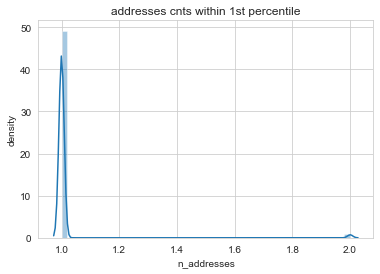

In [348]:
#checking points only within 1st percentile
plt.title('addresses cnts within 1st percentile')
sns.distplot(n_addresses_1perc)
plt.xlabel('n_addresses')
plt.ylabel('density')
plt.show()

In [349]:
dict_address_cnts = dict(X_train['address'].value_counts())
n_address = boxcox(np.array(list(dict_address_cnts.values())))[0]
# 
for index, key in tqdm(enumerate(dict_address_cnts.keys())):
    # updating the dictionary with number of times each address appears with the boxcox transformation applied to fix the skewness
    dict_address_cnts.update({key: address_cnts[index]})
 

0it [00:00, ?it/s]

In [350]:
n_address.min()

0.0

In [351]:
bc_address_n = boxcox(np.array(list(dict_address_cnts.values())))[0] # 
pd.Series(bc_address_n).skew()

5.953107169677995

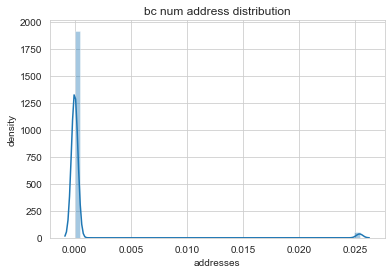

In [352]:
#plot to print distribution of n_addresses
plt.title('bc num address distribution')
sns.distplot(bc_address_n)
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

In [353]:
bc_n_address_train = np.array([])

for index, row in tqdm(X_train.iterrows(), total=X_train.shape[0]):
    # For each address in the training set append the boxcox'd
    # number of times it appears in the training set

    n_address_i = dict_address_cnts.get(X_train.loc[index]['address'])
    
    bc_n_address_train = np.append(bc_n_address_train, n_address_i)

bc_n_address_test = np.array([])
min_dict_n_address = min(list(dict_address_cnts.values()))

for index, row in tqdm(X_test.iterrows(), total=X_test.shape[0]):
    # For each address in the training set append the boxcox'd
    # number of times it appears in the training set
    try:
        #we do the same as above
        n_address_i = dict_address_cnts[X_test.loc[index]['address']]
    except KeyError:
        #KeyError arises when the addreses in training set has not been seen before (i.e cold start)
        #For this, we assign the minimum value to it

        n_address_i = min_dict_n_address #Addressing cold start
    bc_n_address_test = np.append(bc_n_address_test, n_address_i)

  0%|          | 0/561463 [00:00<?, ?it/s]

  0%|          | 0/167711 [00:00<?, ?it/s]

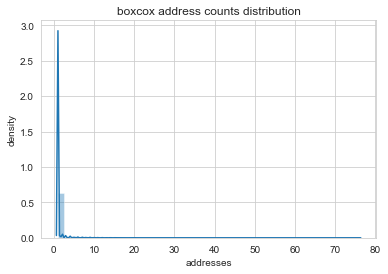

In [354]:
plt.title('boxcox address counts distribution')
sns.distplot(bc_n_address_train)
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

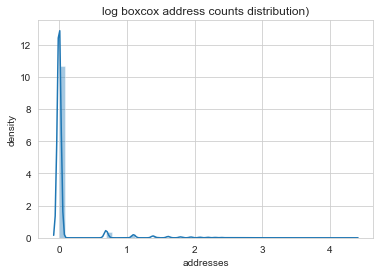

In [355]:
plt.title('log boxcox address counts distribution)')
sns.distplot(np.log(bc_n_address_train)) 
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

In [356]:
logbc_n_address_train = np.log(bc_n_address_train)
logbc_n_address_test = np.log(bc_n_address_test)

In [357]:
train_features_d['logbc_n_address'] = Feature( pd.DataFrame(logbc_n_address_train,
                    columns=['logbc_n_address']),'logbc_n_address' )
test_features_d['logbc_n_address']  = Feature( pd.DataFrame(logbc_n_address_test,
                    columns=['logbc_n_address']),'logbc_n_address' )

In [358]:
train_features_d['logbc_n_address'].skew

4.734594416456778

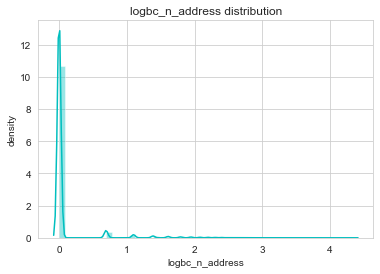

In [359]:
train_features_d['logbc_n_address'].plot_pdf()

#### 2.1.5 neighbors [bc_neighbors]

In [369]:
train_features['neighbors'].series.describe()

count    561463.000000
mean          2.222531
std          23.915774
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max       12920.000000
Name: neighbors, dtype: float64

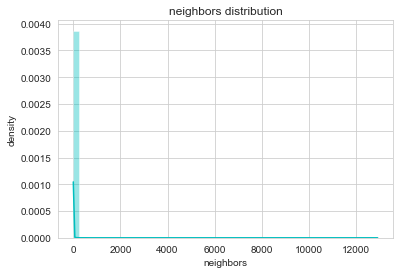

In [370]:
train_features['neighbors'].plot_pdf()

In [371]:
train_features['neighbors'].skew

349.670288068549

In [372]:
# apply boxcox
bc_neighbors_train = train_features['neighbors'].bc()
bc_neighbors_test = test_features['neighbors'].bc()

In [373]:
# generate new feature
train_features_d['bc_neighbors'] = Feature(pd.DataFrame(bc_neighbors_train,
                    columns=['bc_neighbors']),'bc_neighbors')
test_features_d['bc_neighbors'] = Feature( pd.DataFrame(bc_neighbors_test,
                    columns=['bc_neighbors']),'bc_neighbors')

In [374]:
train_features_d['bc_neighbors'].mean# skew is reduced

0.43092982180546063

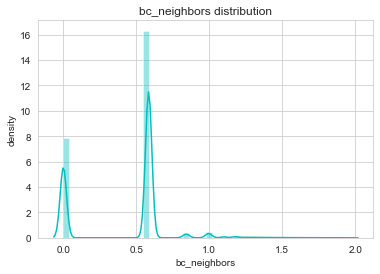

In [375]:
train_features_d['bc_neighbors'].plot_pdf()

In [376]:

dfc[dfc['label'] != 'white'].groupby('label')['neighbors'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
APT,2.0,2.500000,0.707107,2.0,2.25,2.5,2.75,3.0
Cerber,2209.0,2.014939,0.406306,1.0,2.00,2.0,2.00,10.0
CryptConsole,3.0,2.000000,0.000000,2.0,2.00,2.0,2.00,2.0
CryptXXX,617.0,1.972447,0.655312,1.0,2.00,2.0,2.00,6.0
CryptoLocker,2322.0,2.883290,3.439348,1.0,2.00,2.0,3.00,63.0
CryptoTorLocker2015,10.0,7.000000,5.517648,2.0,2.00,5.5,10.50,16.0
CryptoWall,3008.0,1.942819,2.130289,1.0,1.00,1.0,2.00,37.0
DMALocker,50.0,1.880000,1.349830,1.0,1.00,1.0,2.00,6.0
DMALockerv3,93.0,1.161290,0.576540,1.0,1.00,1.0,1.00,5.0


In [377]:

dfc[dfc['label'] == 'white'].groupby('label')['neighbors'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
white,719067.0,2.216711,22.39515,1.0,1.0,2.0,2.0,12920.0


#### 2.1.6 looped  [sig_looped]

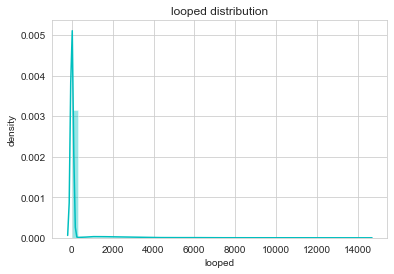

In [378]:
train_features['looped'].plot_pdf()

In [379]:
train_features['looped'].skew

5.544117274510451

In [380]:
# apply sigmoid
sig_looped_train = train_features['looped'].sigmoid()
sig_looped_test  = test_features['looped'].sigmoid()

In [381]:
# generate new feature
train_features_d['sig_looped'] = Feature(pd.DataFrame(sig_looped_train,
                    columns=['sig_looped']),'sig_looped' )
test_features_d['sig_looped'] = Feature(pd.DataFrame(sig_looped_test,
                    columns=['sig_looped']),'sig_looped' )

In [382]:
train_features_d['sig_looped'].skew

2.2215463159882374

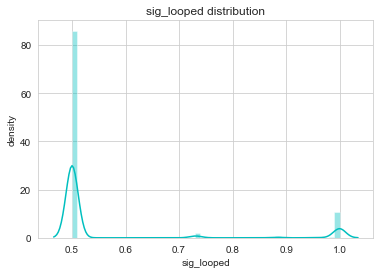

In [383]:
train_features_d['sig_looped'].plot_pdf()

#### 2.1.7 count [log_count]

In [384]:
#X_train_cnt_ft = feature(X_train,'count')
#X_test_cnt_ft  = feature(X_test,'count')

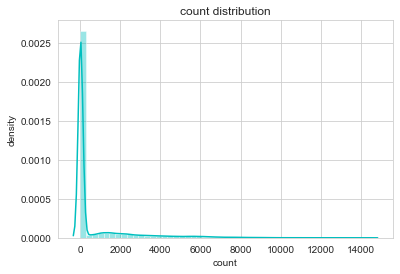

In [385]:
train_features['count'].plot_pdf()

In [386]:
train_features['count'].skew

2.9361537332298413

In [387]:
min(train_features['count'].vec)

1

In [388]:
log_count_train = np.log(train_features['count'].vec)
log_count_test  = np.log(test_features['count'].vec)

In [389]:
# generate new feature
train_features_d['log_count'] = Feature(pd.DataFrame(log_count_train,
                    columns=['log_count']),'log_count')
test_features_d['log_count'] = Feature(pd.DataFrame(log_count_test,
                    columns=['log_count']),'log_count')

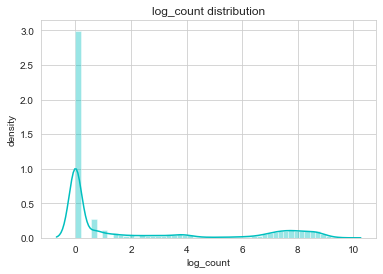

In [390]:
train_features_d['log_count'].plot_pdf()

In [391]:
train_features_d['log_count'].skew

1.0654651240037887

# 3.0 Standardizing and Encoding

In [392]:
list(train_features_d.keys())

['year',
 'bc_income',
 'day',
 'day_of_week',
 'bc_length',
 'yeo_weight',
 'address',
 'logbc_n_address',
 'bc_neighbors',
 'sig_looped',
 'log_count']

In [393]:
# original columns to get scaled for distance based classifiers
cols_orig = [ 
    'year',
    'day',
    'length',
    'weight',
    'count',
    'looped',
    'neighbors',
    'income']
# new columns to get scaled for distance based classifiers
cols_new = [
    'address',
    'bc_income',
    'bc_length',
    'yeo_weight',
    'logbc_n_address',
    'bc_neighbors',
    'sig_looped',
    'log_count',
    'year',
    'day',
    'day_of_week'
]

cols = cols_orig + cols_new
num_to_enc = 1

In [394]:
X_train_d = pd.DataFrame()
X_test_d = pd.DataFrame()

In [395]:
train_features_d

{'year': <__main__.Feature at 0x29cd8f730>,
 'bc_income': <__main__.Feature at 0x2add7b820>,
 'day': <__main__.Feature at 0x2adf09df0>,
 'day_of_week': <__main__.Feature at 0x2ade72460>,
 'bc_length': <__main__.Feature at 0x2bc49db50>,
 'yeo_weight': <__main__.Feature at 0x13af39b50>,
 'address': <__main__.Feature at 0x13ae6cdf0>,
 'logbc_n_address': <__main__.Feature at 0x3137c68b0>,
 'bc_neighbors': <__main__.Feature at 0x313c64610>,
 'sig_looped': <__main__.Feature at 0x313dece20>,
 'log_count': <__main__.Feature at 0x313d62f10>}

In [396]:
X_train_d['address']=train_features['address'].vec

In [397]:
for col in cols_new:
    X_train_d[col] = train_features_d[col].vec
    X_test_d[col] = test_features_d[col].vec


In [398]:
if SAVE_TEST_TRAIN == True:
    with open('derived'+fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)

#### 2.2.1 Scaling and encoding the data

In [399]:
# cols to standardize (0 mean, unit variance)
col_names_standardize = ['bc_income',
                         'bc_length',
                         'yeo_weight',
                         'logbc_n_address',
                         'bc_neighbors',
                         'sig_looped',
                         'log_count']
# cols to encode
col_names_encode = ['day_of_week']
col_names_pass = ['year','address', 'day']

In [400]:
X_train_d

,address,bc_income,bc_length,yeo_weight,logbc_n_address,bc_neighbors,sig_looped,log_count,year,day,day_of_week
0,152PVs5BJXc6ffpnTfodo8gk4459ga2rGo,4.118361,-0.835123,0.002122,1.098612,0.000000,0.5,6.463029,2014,264,6
1,3HsKgPcBZX8LhzAZLbY5yEAvSeJVhe1hyp,4.125074,-1.517506,0.189317,0.000000,0.000000,0.5,0.000000,2016,195,2
2,1BBiuoy7bYaaMkCQNw9TJaM829PrAvML4o,4.106015,-0.063107,0.107866,0.000000,0.584252,0.5,0.000000,2014,183,2
3,1vTKvyRX2JUHJc37vjMjiG5q9qmuPBfsG,4.133130,-0.000639,0.428972,0.000000,0.584252,0.5,0.000000,2014,202,0
4,12aPhUHp4MVEPc94SsoASkEeJXnZmK8sHZ,4.118753,-0.063107,0.003887,0.000000,0.000000,0.5,0.000000,2013,2,2
...,...,...,...,...,...,...,...,...,...,...,...
561458,3F2ndcScfjb3qQUGer3AEFCRgiPdVctJ3K,4.126515,-0.835123,0.499521,0.000000,0.584252,1.0,8.637107,2018,241,2
561459,3DY52Fau1HC1zK2TU7ShyzVqVKhhhTEHvs,4.142881,-0.475318,0.000003,0.000000,0.584252,0.5,0.000000,2018,110,4
561460,1HN2ijH7JECUkwvmGHZWmApfZEm3KP1SRh,4.138220,-0.107729,0.007736,0.000000,0.000000,0.5,0.000000,2011,128,6
561461,1Km6v9iejV2Dv5Q1WcD8NfxQuekqNv1brC,4.126054,-0.454637,0.222847,0.000000,0.584252,0.5,1.098612,2013,287,0


In [401]:
X_train

,address,year,day,length,weight,count,looped,neighbors,income
1389833,152PVs5BJXc6ffpnTfodo8gk4459ga2rGo,2014,264,144,0.002128,641,0,1,1.000000e+08
2050983,3HsKgPcBZX8LhzAZLbY5yEAvSeJVhe1hyp,2016,195,2,0.250000,1,0,1,1.818900e+08
1308993,1BBiuoy7bYaaMkCQNw9TJaM829PrAvML4o,2014,183,14,0.125000,1,0,2,4.000000e+07
1327903,1vTKvyRX2JUHJc37vjMjiG5q9qmuPBfsG,2014,202,22,1.000000,1,0,2,4.270780e+08
762993,12aPhUHp4MVEPc94SsoASkEeJXnZmK8sHZ,2013,2,14,0.003906,1,0,1,1.033284e+08
...,...,...,...,...,...,...,...,...,...
2827069,3F2ndcScfjb3qQUGer3AEFCRgiPdVctJ3K,2018,241,144,1.544710,5637,5625,2,2.093145e+08
2695959,3DY52Fau1HC1zK2TU7ShyzVqVKhhhTEHvs,2018,110,92,0.000003,1,0,2,1.632521e+09
159013,1HN2ijH7JECUkwvmGHZWmApfZEm3KP1SRh,2011,128,12,0.007812,1,0,1,8.150000e+08
1048336,1Km6v9iejV2Dv5Q1WcD8NfxQuekqNv1brC,2013,287,6,0.312500,3,0,2,2.000000e+08


In [402]:
# transform the data for use in distance based modeling algorithms [logistic regression]
transformer = ColumnTransformer(
    [('standardize', StandardScaler(), col_names_standardize),
    ('encode', OneHotEncoder(dtype=int), col_names_encode)],
    remainder = 'passthrough',
     verbose_feature_names_out=False)

transformer.fit(X_train_d)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardize', StandardScaler(),
                                 ['bc_income', 'bc_length', 'yeo_weight',
                                  'logbc_n_address', 'bc_neighbors',
                                  'sig_looped', 'log_count']),
                                ('encode', OneHotEncoder(dtype=<class 'int'>),
                                 ['day_of_week'])],
                  verbose_feature_names_out=False)

In [403]:
# std. transformed and encoded variables (np arrays)
X_train_e = transformer.transform(X_train_d)
X_test_e  = transformer.transform(X_test_d)
# std. transformed and encoded variables (df with verbose headers)

X_train_e_df = pd.DataFrame(X_train_e,columns=transformer.get_feature_names_out())
X_test_e_df = pd.DataFrame(X_test_e,columns=transformer.get_feature_names_out())

In [404]:
if SAVE_TEST_TRAIN == True:
    with open('encoded'+fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)


# 3.0 Resampling

In [405]:
print('Training set has {} rows and {} columns.'.format(X_train.shape[0], X_train.shape[1]))
print('Testing set has {} rows and {} columns.'.format(X_test.shape[0], X_test.shape[1]))
print('Training set has {} points that belong to postitive class (ransomware) and {} points that belong to negative class (white).'.format(
    sum(y_train['labels']),
    len(y_train['labels']) - sum(y_train['labels'])
))
print('Percentage of positive class data-points: {:.2f}%'.format((sum(y_train['labels'])/(len(y_train['labels'])) * 100)))

Training set has 561463 rows and 9 columns.
Testing set has 167711 rows and 9 columns.
Training set has 7782 points that belong to postitive class (ransomware) and 553681 points that belong to negative class (white).
Percentage of positive class data-points: 1.39%


## 2.1 Sampling

In [406]:
from imblearn.over_sampling import SMOTE


### 2.1.0 Downsampling

In [407]:
class Sampler:

    def __init__(self,X):
        self.X_df = pd.DataFrame(X)
        self.positive_df = pd.DataFrame([], columns = self.X_df.columns)
        self.negative_df = pd.DataFrame([], columns = self.X_df.columns)
        self.combined_df = pd.DataFrame([], columns = self.X_df.columns)
        self.X_train_sm =  pd.DataFrame([], columns = self.X_df.columns)
        self.y_train_sm =  pd.DataFrame([], columns = ['lables'])
        self.X_train_rus = pd.DataFrame([], columns = self.X_df.columns)
        self.y_train_rus =  pd.DataFrame([], columns = ['lables'])



    def up_samp_smote(self, X_train, y_train, ratio):
        """Upsamples minority class using SMOTE.
        Ratio argument is the percentage of the upsampled minority class in relation
        to the majority class.
        """
        sm = SMOTE(random_state=RAND_STATE, sampling_strategy=ratio)
        X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
        #print(len(X_train_sm), len(y_train_sm))
        self.X_train_sm, self.y_train_sm = X_train_sm, y_train_sm


    def down_samp_rand(self, X_train, y_train, ratio):
        """Downsamples majority class using random sampling.
        Ratio argument is the ratio of minority class to the downsampled majority
        """
        rus = RandomUnderSampler(sampling_strategy=ratio,random_state=RAND_STATE)
        X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
        self.X_train_rus, self.y_train_rus = X_train_rus, y_train_rus


    def down_samp(self, y_train, prob=0.015):
        index = 0

        for index_df, row in tqdm(self.X_df.iterrows(), total=self.X_df.shape[0]):
            if y_train[index] == 0:
                if np.random.uniform(0, 1) < prob:
                    #picking negative class with a probability=prob
                    self.negative_df = self.negative_df.append(row, ignore_index=True)
                    index += 1
                else:
                    index += 1
            elif y_train[index] == 1:
            #picking all positive data-points
                self.positive_df = self.positive_df.append(row, ignore_index=True)
                index += 1
        self.combined_df = self.positive_df.append(self.negative_df, ignore_index = True)

**e_ds** <n>
- Encoded, standard scaled, and normalized data.
- Split of X_train_e [standardized, encoded] without column headers.

In [408]:
X_train_e_df.drop(columns=['address'],axis=1,inplace=True)

In [409]:
# Create a sample object
e_ds = Sampler(X_train_e_df)

In [410]:
e_ds.down_samp_rand(X_train_e_df, y_train['labels'], 0.05) # downsample using random resampling

In [411]:
e_ds.up_samp_smote(e_ds.X_train_rus, e_ds.y_train_rus, 0.25) # upsampling using SMOTE

In [412]:
READ_STATE = False

# 4.0 Modeling

In [414]:
def plot_roc(model, X, y, plot_title):
    plot_roc_curve(model, X, y)
    plt.title(plot_title)
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
    plt.legend()
    plt.show()


def confusion_mat(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')


def tabulate_scores_df(model_name, y_test, y_pred):
    df2 = pd.DataFrame([[
        model_name,
        accuracy_score(y_true=y_test, y_pred=y_pred),
        precision_score(y_true=y_test, y_pred=y_pred),
        recall_score(y_true=y_test, y_pred=y_pred),
        f1_score(y_true=y_test, y_pred=y_pred)]],
        columns=['Type', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

    return df2


In [521]:
class Model:
    def __init__(self, x_tr, y_tr, X_tr, X_tst, routine, params, classifier, crss_vldtr=None):
        '''Model'''
        self.classifier = classifier
        self.X_tst = X_tst


        #  randomized search on hyper parameters
        search = RandomizedSearchCV(
            estimator = routine,
            param_distributions = params,
            scoring = 'accuracy',
            cv = crss_vldtr,
            n_jobs = -1,
            verbose = 1,
            random_state = RAND_STATE,
            return_train_score = True,
            n_iter = 5
        )
        if READ_STATE == True:
            tag = input('Enter head of parameter file to read')
            rf_hps_fname = tag + '_bestparams_sm_e_05.csv'
            print('reading file ', rf_hps_fname)
            bps = pd.read_csv(rf_hps_fname, index_col=False).to_dict('list')
            bps.pop('Unnamed: 0')
            ks = [k for k in bps.keys()]
            vs = [v[0] for v in bps.values()]
            self.best_params = dict( zip(ks,vs) )
        else:
            search.fit(x_tr, y_tr)
            self.best_params = search.best_params_

        print(self.best_params)
        tuned = classifier(**self.best_params,# n_jobs = -1,
                            random_state = RAND_STATE)
        self.tuned = tuned
        # fit
        tuned.fit(x_tr, y_tr)
        # predict
        self.preds_train = tuned.predict(X_tr)
        self.preds_test  = tuned.predict(X_tst)
        self.params      = tuned.get_params()

    def score(self,y_tr,y_tst):
        trn_score_df = tabulate_scores_df('trn', y_tr, self.preds_train)
        tst_score_df = tabulate_scores_df('tst', y_tst, self.preds_test)
        score_df = trn_score_df.append(tst_score_df)
        return score_df

    def roc(self, y_tst, title):
        plot_roc(self.tuned, self.X_tst,y_tst, title)

    def conf_mat(self, y_tr, y_tst):
        plt.figure(figsize=(15,7))

        plt.subplot(1,2,1) # first heatmap
        confusion_mat(y_tr, self.preds_train)

        plt.subplot(1,2,2) # first heatmap
        confusion_mat(y_test, self.preds_test)

        plt.show()

    def feature_imps(self,colnames):
        feat_ranks_df = pd.DataFrame(np.ravel(self.tuned.feature_importances_), index=colnames)
        feat_ranks_df.columns = ['feature importance']
        feat_ranks_df.sort_values(by='feature importance', ascending=False)
        return feat_ranks_df

In [417]:
from collections import Counter
counter = Counter(y_train['labels'])
estimate = np.sqrt(counter[0] / counter[1])

In [419]:
from sklearn.svm import LinearSVC

In [420]:
models = {
    "sgd": { "estimater": SGDClassifier(),
             "params": {
                 "loss" : [ "log_loss", "perceptron"],
                 "alpha" : [0.0001, 0.001, 0.01, 0.1],
                 "penalty" : ["l2", "l1", "elasticnet"],
                 "class_weight" : ['balanced', None],}
             },
    "rf": { "estimater": RandomForestClassifier(),
            "params": {
                'max_depth' : [2,5,10,15],
                'n_estimators' : [100, 500, 1000],
                "class_weight" : ['balanced', None],}
            },
    "xgb": {"estimater": XGBClassifier(),
            "params": {
                'n_estimators': stats.randint(150, 1000),
                'learning_rate': stats.uniform(0.01, 0.59),
                'subsample': stats.uniform(0.3, 0.6),
                'max_depth': [3, 4, 5, 6, 7],
                'colsample_bytree': stats.uniform(0.5, 0.4),
                'scale_pos_weight' : stats.uniform(estimate,estimate**2),
                'min_child_weight': [1, 2, 3, 4],}
            },
    "lsvc": { "estimater": LinearSVC(),
              "params": { }
              },
    "svc": { "estimater": SVC(),
             "params": {
                 'C': [0.1,1, 10, 100, 1000],
                 'gamma': [1,0.1,0.01,0.001,0.0001],
                 'kernel': ['rbf'],}
             }
}

In [421]:
X_test_e_df.drop(columns=['address'],axis=1,inplace=True)

In [422]:
# Create model
sgd_cl = SGDClassifier(random_state=RAND_STATE, max_iter=3000, learning_rate='optimal')
sgd_params_in = {
    "loss": ["log_loss", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "penalty": ["l2", "l1", "elasticnet"],
    "class_weight": ['balanced', None]
}
sgd = Model(
    e_ds.X_train_sm, e_ds.y_train_sm,
    X_train_e_df, X_test_e_df,
    sgd_cl, sgd_params_in, SGDClassifier)
sgd.params

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'penalty': 'l1', 'loss': 'perceptron', 'class_weight': 'balanced', 'alpha': 0.1}


{'alpha': 0.1,
 'average': False,
 'class_weight': 'balanced',
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'perceptron',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l1',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [423]:
sgd.score(y_train,y_test)

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.924273,0.084895,0.456438,0.143162
0,tst,0.952561,0.121012,0.386667,0.184335


Compare result to original features

In [ ]:
# Create model
sgd_cl0 = SGDClassifier(random_state=RAND_STATE, max_iter=4000, learning_rate='optimal',n_jobs=-1)
sgd_params_in = {
    "loss": [ "perceptron"],
    "alpha": [ 0.1],
    "penalty": ["l2", "l1", "elasticnet"],
    "class_weight": ['balanced', None]
}
sgd0 = Model(
    X_train.drop(labels=['address'],axis=1), y_train['labels'],
    X_train.drop(labels=['address'],axis=1), X_test.drop(labels=['address'],axis=1),
    sgd_cl0, sgd_params_in, SGDClassifier)
sgd0.params

KeyboardInterrupt: 

In [520]:
sgd0.score(y_train,y_test)

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.013860,0.013860,1.0,0.027341
0,tst,0.013863,0.013863,1.0,0.027347
